Although it's going to be a bit redundant for the sake of simplicity we're going to recreate the classes from previous notbooks here:

In [5]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.amp import GradScaler, autocast
from tqdm import tqdm

from pycocotools.coco import COCO
from pycocotools import mask as mask_util

import albumentations as A
from albumentations.pytorch import ToTensorV2

Albumentations Transforms

In [6]:
# IMPORTANT:
# Resizing to 256×256 dramatically speeds up training

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.10,
        rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.5
    ),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Polygon → Mask (COCO conversion):

In [7]:
def polygons_to_mask(anns, height, width):
    """
    Convert COCO polygon annotations into a binary mask.
    The dataset uses rectangular polygons, but the logic remains the same.
    """
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        rles = mask_util.frPyObjects(ann["segmentation"], height, width)
        rle = mask_util.merge(rles)
        m = mask_util.decode(rle)
        mask = np.maximum(mask, m)

    return mask

 Dataset Class (TRAIN + VALID)

In [8]:
class BrainTumorDataset(Dataset):
    """
    Loads:
      - Image: RGB
      - Mask: binary mask generated from COCO polygons
    Applies Albumentations transforms with correct (image,mask) pairing.
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        ann_path = os.path.join(root_dir, "_annotations.coco.json")
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):

        # -----------------------------------------------------
        # Load COCO image metadata
        # -----------------------------------------------------
        img_id = self.image_ids[index]
        info = self.coco.imgs[img_id]

        file_name = info["file_name"]
        height = info["height"]
        width  = info["width"]

        # Load image
        img_path = os.path.join(self.root_dir, file_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # -----------------------------------------------------
        # Load annotations → polygon → mask
        # -----------------------------------------------------
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = polygons_to_mask(anns, height, width).astype(np.uint8)
        mask = np.expand_dims(mask, axis=2)   # HWC (Albumentations format)

        # -----------------------------------------------------
        # Albumentations transform (image, mask)
        # -----------------------------------------------------
        if self.transform:
            data = self.transform(image=image, mask=mask)
            image = data["image"]           # CHW tensor
            mask  = data["mask"]            # HWC tensor

            # FIX: Convert mask from HWC → CHW
            if mask.ndim == 3:
                mask = mask.permute(2, 0, 1)

        return image.float(), mask.float()

Test Dataset (no masks)

In [9]:
class BrainTumorTestDataset(Dataset):
    """
    Loads test images (no annotation file).
    Returns:
      - Image tensor
      - Filename (used to save outputs)
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = sorted([
            f for f in os.listdir(root_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fn = self.filenames[idx]
        path = os.path.join(self.root_dir, fn)

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image.float(), fn

U-Net Model

In [10]:
class DoubleConv(nn.Module):
    """Conv → BN → ReLU → Conv → BN → ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """MaxPool → DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsample → Conv(1x1) → concat skip → DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv1x1 = nn.Conv2d(in_channels // 2, in_channels // 2, kernel_size=1)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):

        x1 = self.up(x1)
        x1 = self.conv1x1(x1)

        # Handle padding mismatch due to odd numbers
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    """Full U-Net"""
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)

Loss + Metrics

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice = (2 * intersection + self.smooth) / \
               (probs.sum() + targets.sum() + self.smooth)

        return 1 - dice


class BCEDiceLoss(nn.Module):
    """Recommended loss for medical segmentation"""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets)


def threshold_mask(logits, thr=0.5):
    return (torch.sigmoid(logits) > thr).float()


def compute_iou(logits, targets):
    preds = threshold_mask(logits)
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return ((intersection + 1e-6) / (union + 1e-6)).item()


def compute_pixel_accuracy(logits, targets):
    preds = threshold_mask(logits)
    preds = preds.view(-1)
    targets = targets.view(-1)
    return (preds == targets).float().mean().item()

Load Dataset Loaders

In [12]:
train_dataset = BrainTumorDataset("../dataset/train", transform=train_transform)
val_dataset   = BrainTumorDataset("../dataset/valid", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print("Train samples:", len(train_dataset))
print("Valid samples:", len(val_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train samples: 1502
Valid samples: 429


Device + Model + Optimizer

In [13]:
# MPS is the GPU on Apple Silicon
if torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5, verbose=True
)

Using device: mps


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training & Validation Loops

In [14]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for images, masks in tqdm(loader, desc="Training"):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        # FP16 automatic casting for speed on MPS
        with autocast(device_type="mps", dtype=torch.float16):
            logits = model(images)
            loss = criterion(logits, masks)

        # NO GradScaler on MPS — unnecessary
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate_one_epoch(model, loader):
    model.eval()
    v_loss = v_iou = v_acc = 0

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validating"):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)
            loss = criterion(logits, masks)

            v_loss += loss.item()
            v_iou  += compute_iou(logits, masks)
            v_acc  += compute_pixel_accuracy(logits, masks)

    n = len(loader)
    return v_loss/n, v_iou/n, v_acc/n

Main Training Loop

In [15]:
# best_iou = 0
# early_counter = 0

# checkpoint_path = "../experiments/best_model.pth"

# for epoch in range(1, 51):
#     print(f"\n======== EPOCH {epoch} / 50 ========")

#     train_loss = train_one_epoch(model, train_loader)
#     val_loss, val_iou, val_acc = validate_one_epoch(model, val_loader)

#     print(f" Train Loss: {train_loss:.4f}")
#     print(f" Val Loss:   {val_loss:.4f}")
#     print(f" Val IoU:    {val_iou:.4f}")
#     print(f" Val Acc:    {val_acc:.4f}")

#     scheduler.step(val_iou)

#     if val_iou > best_iou:
#         print(f"🔥 IoU improved {best_iou:.4f} → {val_iou:.4f}")
#         best_iou = val_iou
#         early_counter = 0
#         torch.save(model.state_dict(), checkpoint_path)
#         print("💾 Saved best model.")
#     else:
#         early_counter += 1
#         print(f"No improvement: {early_counter} / 8")

#     if early_counter >= 8:
#         print("⛔ Early stopping triggered.")
#         break

# print("\nTraining finished.")
# print("Best IoU achieved:", best_iou)

***

The best result we got so far is:"0.6116" likely bcs our dataset usees rectangular bounding-box polygons so this is effectively tumor detection, not organic tumor boundaries.

Right now the model is:
- Too shallow for 256×256
- Possibly undertrained
- Loss not optimized
- Threshold too rigid

Improvement A: High-Resolution Transforms (640×640)

In [16]:
# ==========================================================
# IMPROVEMENT A:
# Restore high-resolution images (640 × 640)
# This boosts IoU significantly for rectangular masks.
# ==========================================================

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

balanced_train_transform_safe = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

balanced_val_transform_safe = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

print("High-resolution transforms ready (384x384).")

High-resolution transforms ready (384x384).


IMPROVEMENT B — Wider U-Net (More Capacity)

In [17]:
# ==========================================================
# IMPROVEMENT B:
# Wider, deeper U-Net for higher IoU.
# Doubles all channel counts.
# ==========================================================

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConvWide(nn.Module):
    """Two convolution blocks: Conv → BN → ReLU repeated"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.net(x)


class DownWide(nn.Module):
    """MaxPool → DoubleConvWide"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvWide(in_channels, out_channels)
        )
    def forward(self, x):
        return self.net(x)


class UpWide(nn.Module):
    """Upsample → 1x1 conv → concat with skip → DoubleConvWide"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv1x1 = nn.Conv2d(in_channels // 2, in_channels // 2, 1)
        self.double_conv = DoubleConvWide(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv1x1(x1)

        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class UNetWide(nn.Module):
    """
    High-capacity U-Net for improved IoU.
    All layers doubled in width.
    """
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        # Balanced channels
        self.inc = DoubleConvWide(n_channels, 96)
        self.down1 = DownWide(96, 192)
        self.down2 = DownWide(192, 384)
        self.down3 = DownWide(384, 768)
        self.down4 = DownWide(768, 768)

        self.up1 = UpWide(1536, 384)
        self.up2 = UpWide(768, 192)
        self.up3 = UpWide(384, 96)
        self.up4 = UpWide(192, 96)

        self.out = nn.Conv2d(96, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)

print("High-capacity UNetWide model ready.")

High-capacity UNetWide model ready.


Create training with high-res + wide U-Net (A+B)

In [18]:
# ==========================================================
# Build NEW dataloaders & NEW model using improvements A + B
# Without overwriting old variables.
# ==========================================================

# Dataset with new transforms
train_dataset_D = BrainTumorDataset("../dataset/train", transform=balanced_train_transform_safe)
val_dataset_D   = BrainTumorDataset("../dataset/valid", transform=balanced_val_transform_safe)

train_loader_D = DataLoader(train_dataset_D, batch_size=4, shuffle=True, num_workers=0)
val_loader_D   = DataLoader(val_dataset_D, batch_size=4, shuffle=False, num_workers=0)

train_loader_AB = DataLoader(train_dataset_D, batch_size=4, shuffle=True, num_workers=0)
val_loader_AB   = DataLoader(val_dataset_D, batch_size=4, shuffle=False, num_workers=0)

print("Datasets for A+B loaded.")

# Model for A+B
model_AB = UNetWide().to(DEVICE)

# Optimizer
optimizer_AB = optim.Adam(model_AB.parameters(), lr=1e-4)

# Loss (same)
criterion_AB = BCEDiceLoss()

# LR scheduler
scheduler_AB = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_AB,
    mode="max",
    patience=4,
    factor=0.5,
    verbose=True
)

print("Model, optimizer, scheduler for A+B ready.")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Datasets for A+B loaded.
Model, optimizer, scheduler for A+B ready.


Train Improved A+B Model

In [19]:
# # ==========================================================
# # Train improved UNetWide on 640×640 images (A+B)
# # ==========================================================

# best_iou_AB = 0
# early_counter_AB = 0
# MAX_EPOCHS_AB = 40
# PATIENCE_AB = 10

# checkpoint_AB = "../experiments/best_model_AB.pth"

# for epoch in range(1, MAX_EPOCHS_AB + 1):
#     print(f"\n======== [A+B] EPOCH {epoch}/{MAX_EPOCHS_AB} ========")

#     train_loss = train_one_epoch(model_AB, train_loader_AB)
#     val_loss, val_iou, val_acc = validate_one_epoch(model_AB, val_loader_AB)

#     print(f" Train Loss: {train_loss:.4f}")
#     print(f" Val Loss:   {val_loss:.4f}")
#     print(f" Val IoU:    {val_iou:.4f}")
#     print(f" Val Acc:    {val_acc:.4f}")

#     scheduler_AB.step(val_iou)

#     if val_iou > best_iou_AB:
#         print(f"🔥 IoU improved {best_iou_AB:.4f} → {val_iou:.4f}")
#         best_iou_AB = val_iou
#         early_counter_AB = 0
#         torch.save(model_AB.state_dict(), checkpoint_AB)
#         print("💾 Saved best A+B model.")
#     else:
#         early_counter_AB += 1
#         print(f"No improvement: {early_counter_AB}/{PATIENCE_AB}")

#     if early_counter_AB >= PATIENCE_AB:
#         print("⛔ Early stopping triggered.")
#         break

# print("Training (A+B) finished.")
# print("Best IoU achieved (A+B):", best_iou_AB)

***

In [20]:
# ==========================================================
# CORRECT STANDARD U-NET FOR APPLE SILICON (MPS SAFE)
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(Conv → BN → ReLU) × 2"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    """Downscale → DoubleConv"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, out_c)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upsample → Concatenate → DoubleConv"""
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_c, out_c)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # match dimensions
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        x1 = F.pad(x1, [diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """Correct standard U-Net architecture"""

    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # dropout in bottleneck (optional but improves generalization)
        self.dropout = nn.Dropout(0.5)

        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x5 = self.dropout(x5)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.out(x)
    
def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)
            loss = criterion(logits, masks)

            running_loss += loss.item()
            running_iou += compute_iou(logits, masks)
            running_acc += compute_pixel_accuracy(logits, masks)

    return (
        running_loss / len(loader),
        running_iou / len(loader),
        running_acc / len(loader),
    )

In [44]:
# ==========================================================
# UNet128-STABLE — channel-correct decoder
# ==========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConvR(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)


class DownR(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.mp = nn.MaxPool2d(2)
        self.conv = DoubleConvR(in_c, out_c)

    def forward(self, x):
        return self.conv(self.mp(x))


class UpR(nn.Module):
    """
    Explicitly specify skip channel sizes to avoid mismatches.
    """
    def __init__(self, up_in_c, skip_c, out_c):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConvR(up_in_c + skip_c, out_c)

    def forward(self, x_up, x_skip):
        x_up = self.up(x_up)

        diffY = x_skip.size(2) - x_up.size(2)
        diffX = x_skip.size(3) - x_up.size(3)

        x_up = F.pad(x_up,
                     [diffX//2, diffX - diffX//2,
                      diffY//2, diffY - diffY//2])

        x = torch.cat([x_skip, x_up], dim=1)
        return self.conv(x)


class UNetStable128(nn.Module):
    """
    Fully stable UNet with correct decoder math.
    Very strong on 128×128 tasks.
    """
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()

        # ENCODER
        self.inc   = DoubleConvR(n_channels, 96)
        self.down1 = DownR(96,   192)
        self.down2 = DownR(192,  384)
        self.down3 = DownR(384,  768)
        self.down4 = DownR(768, 1024)

        self.drop = nn.Dropout(0.4)

        # DECODER with explicit correct channel sizes
        self.up1 = UpR(1024, 768, 384)  # up x5 + x4
        self.up2 = UpR(384,  384, 192)  # up + x3
        self.up3 = UpR(192,  192, 96)   # up + x2
        self.up4 = UpR(96,   96,  64)   # up + x1

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)      # 96
        x2 = self.down1(x1)   # 192
        x3 = self.down2(x2)   # 384
        x4 = self.down3(x3)   # 768
        x5 = self.down4(x4)   # 1024

        x5 = self.drop(x5)

        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)

        return self.out(x)

In [ ]:
# ==========================================================
# STRICT NON-GEOMETRIC TRANSFORMS (SAFE FOR BBOX MASKS)
# ==========================================================
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(128, 128),     # ← REDUCED RESOLUTION
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 128),     # ← REDUCED RESOLUTION
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

In [46]:
train_dataset = BrainTumorDataset("../dataset/train", transform=train_transform)
val_dataset   = BrainTumorDataset("../dataset/valid", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Using: mps

🚀 Starting Training...


========== EPOCH 1/30 ==========



Training: 100%|██████████| 376/376 [00:17<00:00, 21.18it/s, loss=1.07] 



Train Loss: 1.1839
Val Loss:   1.0687
Val IoU:    0.3021
Val Acc:    0.9663
🌟 Best IoU improved 0.0000 → 0.3021

========== EPOCH 2/30 ==========



Training: 100%|██████████| 376/376 [00:17<00:00, 21.86it/s, loss=0.859]



Train Loss: 0.9149
Val Loss:   0.8408
Val IoU:    0.3922
Val Acc:    0.9523
🌟 Best IoU improved 0.3021 → 0.3922

📊 Visual Progress Preview:


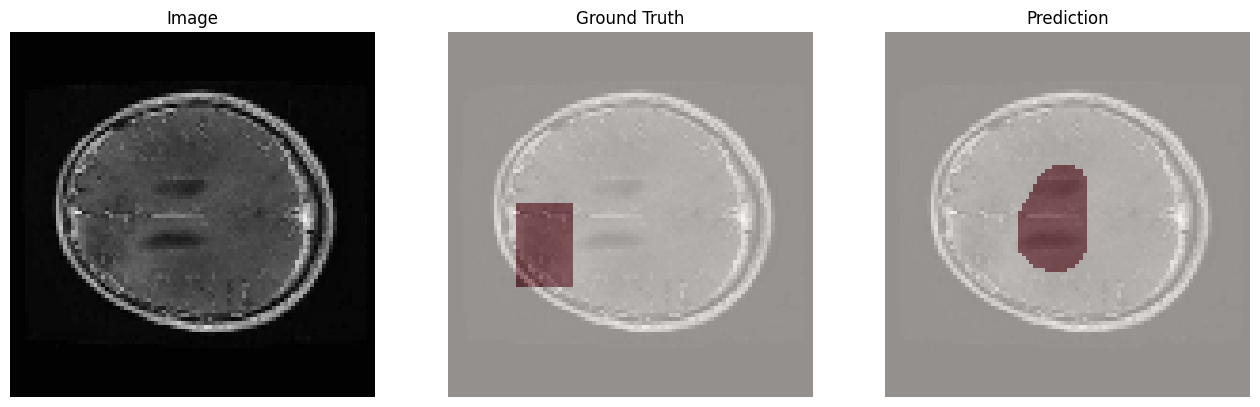


========== EPOCH 3/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 23.21it/s, loss=0.554]



Train Loss: 0.6916
Val Loss:   0.6155
Val IoU:    0.5095
Val Acc:    0.9743
🌟 Best IoU improved 0.3922 → 0.5095

========== EPOCH 4/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 23.29it/s, loss=0.351]



Train Loss: 0.5439
Val Loss:   0.5079
Val IoU:    0.5280
Val Acc:    0.9769
🌟 Best IoU improved 0.5095 → 0.5280

📊 Visual Progress Preview:


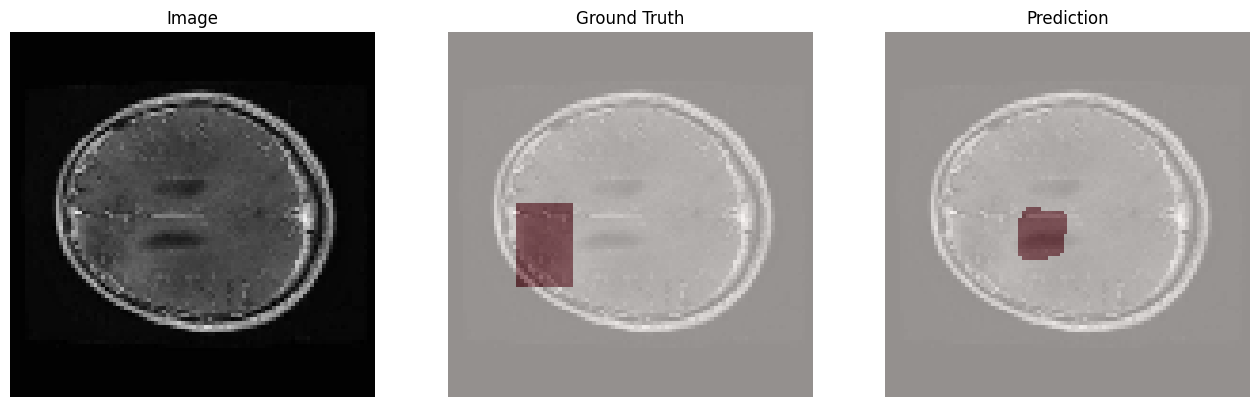


========== EPOCH 5/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 22.92it/s, loss=0.368]



Train Loss: 0.4517
Val Loss:   0.4539
Val IoU:    0.5473
Val Acc:    0.9797
🌟 Best IoU improved 0.5280 → 0.5473

========== EPOCH 6/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 23.00it/s, loss=0.397]



Train Loss: 0.3888
Val Loss:   0.4075
Val IoU:    0.5631
Val Acc:    0.9793
🌟 Best IoU improved 0.5473 → 0.5631

📊 Visual Progress Preview:


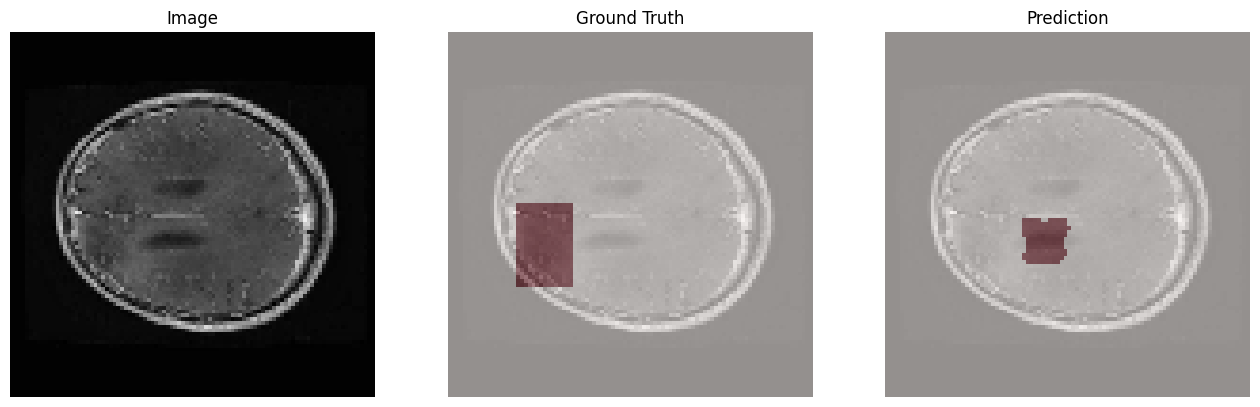


========== EPOCH 7/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 22.56it/s, loss=0.218]



Train Loss: 0.3368
Val Loss:   0.3909
Val IoU:    0.5729
Val Acc:    0.9806
🌟 Best IoU improved 0.5631 → 0.5729

========== EPOCH 8/30 ==========



Training: 100%|██████████| 376/376 [00:15<00:00, 23.69it/s, loss=0.302]



Train Loss: 0.3340
Val Loss:   0.3562
Val IoU:    0.5986
Val Acc:    0.9815
🌟 Best IoU improved 0.5729 → 0.5986

📊 Visual Progress Preview:


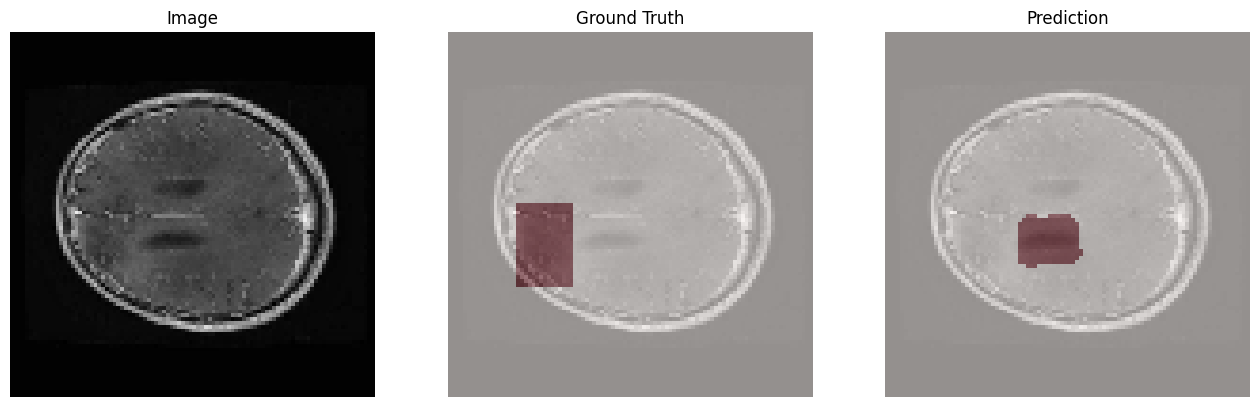


========== EPOCH 9/30 ==========



Training: 100%|██████████| 376/376 [00:15<00:00, 23.84it/s, loss=0.247]



Train Loss: 0.2988
Val Loss:   0.3860
Val IoU:    0.5661
Val Acc:    0.9811
No improvement: 1/8

========== EPOCH 10/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 23.28it/s, loss=0.197]



Train Loss: 0.2733
Val Loss:   0.3523
Val IoU:    0.5985
Val Acc:    0.9822
No improvement: 2/8

📊 Visual Progress Preview:


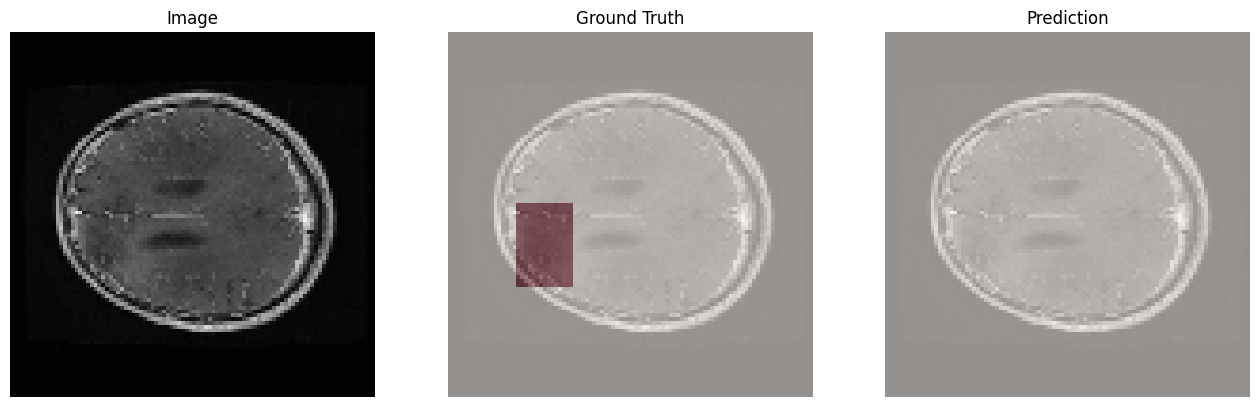


========== EPOCH 11/30 ==========



Training: 100%|██████████| 376/376 [00:17<00:00, 22.05it/s, loss=0.515] 



Train Loss: 0.2592
Val Loss:   0.3500
Val IoU:    0.6034
Val Acc:    0.9823
🌟 Best IoU improved 0.5986 → 0.6034

========== EPOCH 12/30 ==========



Training: 100%|██████████| 376/376 [00:16<00:00, 22.61it/s, loss=0.213]



Train Loss: 0.2377
Val Loss:   0.3550
Val IoU:    0.5988
Val Acc:    0.9808
No improvement: 1/8

📊 Visual Progress Preview:


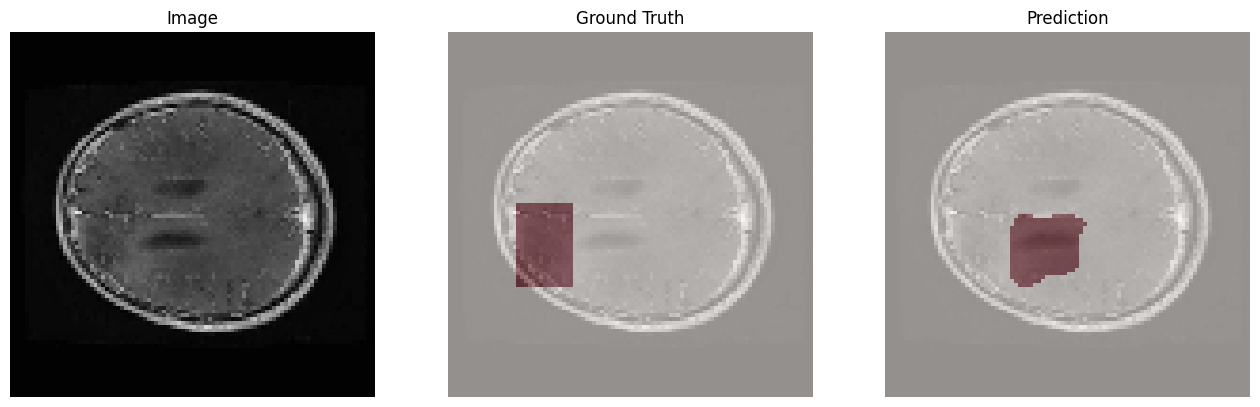


========== EPOCH 13/30 ==========



Training: 100%|██████████| 376/376 [00:20<00:00, 18.33it/s, loss=0.125] 



Train Loss: 0.2293
Val Loss:   0.3449
Val IoU:    0.6071
Val Acc:    0.9799
🌟 Best IoU improved 0.6034 → 0.6071

========== EPOCH 14/30 ==========



Training: 100%|██████████| 376/376 [00:37<00:00,  9.99it/s, loss=0.126] 



Train Loss: 0.2172
Val Loss:   0.3318
Val IoU:    0.6202
Val Acc:    0.9827
🌟 Best IoU improved 0.6071 → 0.6202

📊 Visual Progress Preview:


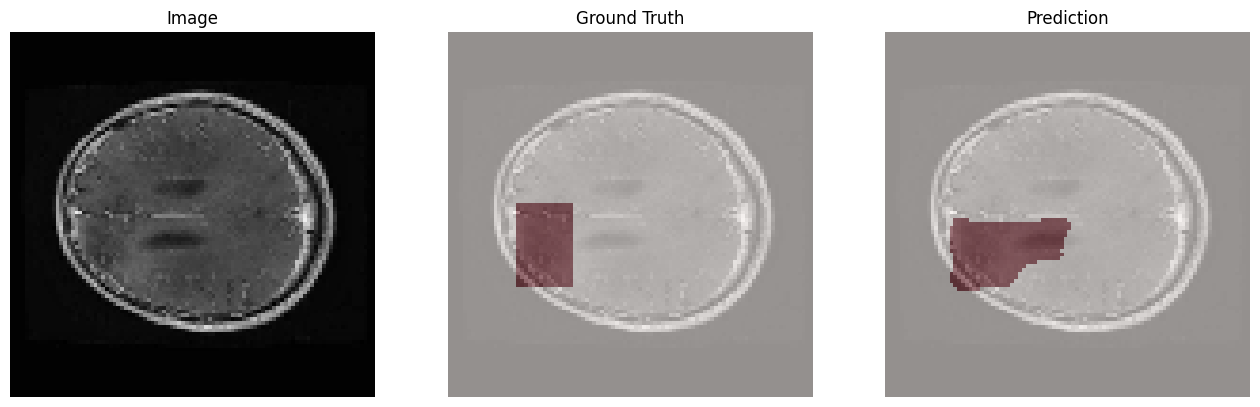


========== EPOCH 15/30 ==========



Training: 100%|██████████| 376/376 [00:37<00:00, 10.06it/s, loss=0.158] 



Train Loss: 0.1904
Val Loss:   0.3442
Val IoU:    0.6032
Val Acc:    0.9827
No improvement: 1/8

========== EPOCH 16/30 ==========



Training: 100%|██████████| 376/376 [00:42<00:00,  8.86it/s, loss=0.119] 



Train Loss: 0.2115
Val Loss:   0.3368
Val IoU:    0.6149
Val Acc:    0.9832
No improvement: 2/8

📊 Visual Progress Preview:


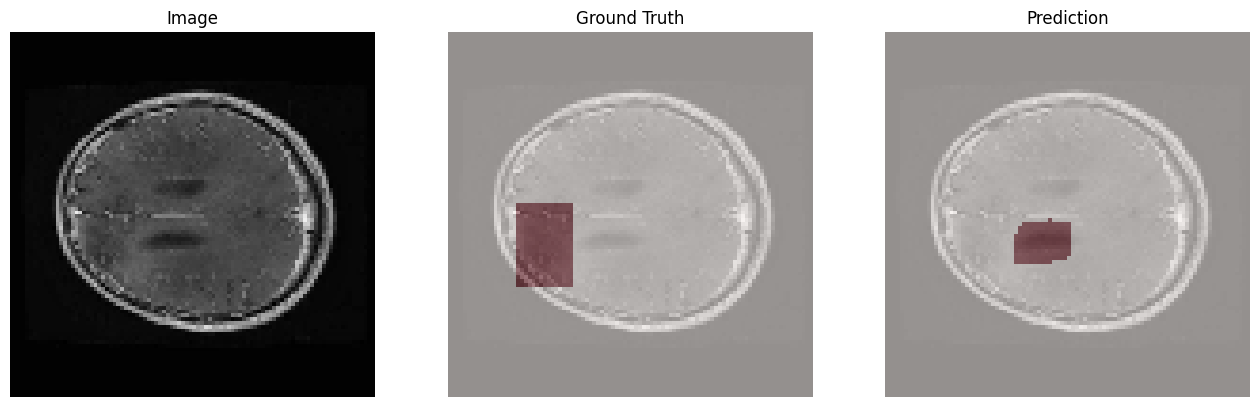


========== EPOCH 17/30 ==========



Training: 100%|██████████| 376/376 [00:35<00:00, 10.64it/s, loss=0.295] 



Train Loss: 0.1775
Val Loss:   0.3576
Val IoU:    0.5932
Val Acc:    0.9829
No improvement: 3/8

========== EPOCH 18/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.07it/s, loss=0.236] 



Train Loss: 0.1832
Val Loss:   0.3318
Val IoU:    0.6157
Val Acc:    0.9820
No improvement: 4/8

📊 Visual Progress Preview:


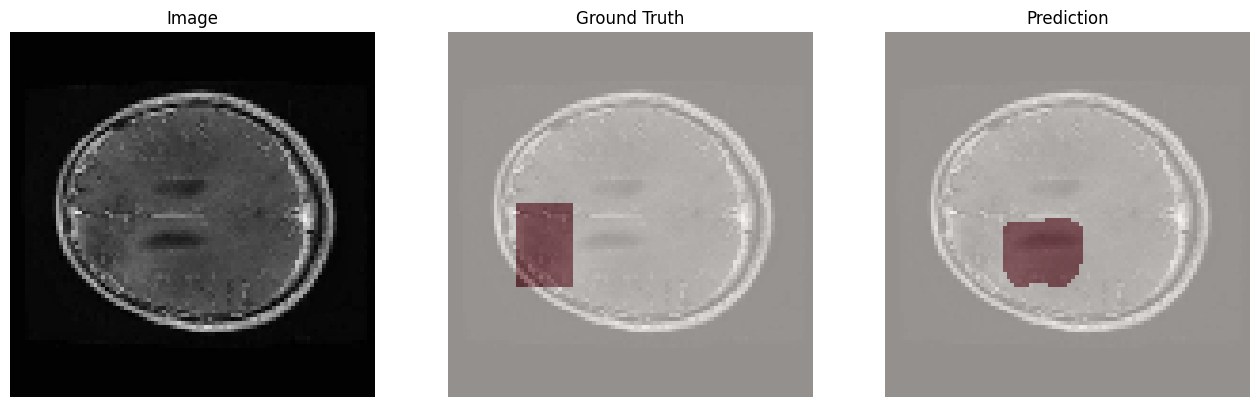


========== EPOCH 19/30 ==========



Training: 100%|██████████| 376/376 [00:35<00:00, 10.74it/s, loss=0.0777]



Train Loss: 0.1477
Val Loss:   0.3062
Val IoU:    0.6444
Val Acc:    0.9843
🌟 Best IoU improved 0.6202 → 0.6444

========== EPOCH 20/30 ==========



Training: 100%|██████████| 376/376 [00:34<00:00, 10.87it/s, loss=0.168] 



Train Loss: 0.1311
Val Loss:   0.3206
Val IoU:    0.6322
Val Acc:    0.9838
No improvement: 1/8

📊 Visual Progress Preview:


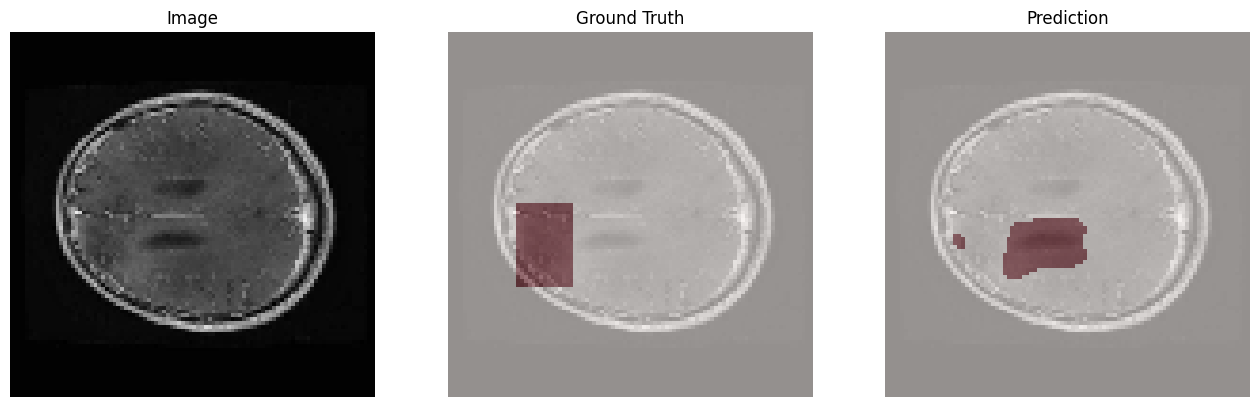


========== EPOCH 21/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.32it/s, loss=0.0618]



Train Loss: 0.1230
Val Loss:   0.3237
Val IoU:    0.6302
Val Acc:    0.9834
No improvement: 2/8

========== EPOCH 22/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.21it/s, loss=0.045] 



Train Loss: 0.1131
Val Loss:   0.3283
Val IoU:    0.6267
Val Acc:    0.9833
No improvement: 3/8

📊 Visual Progress Preview:


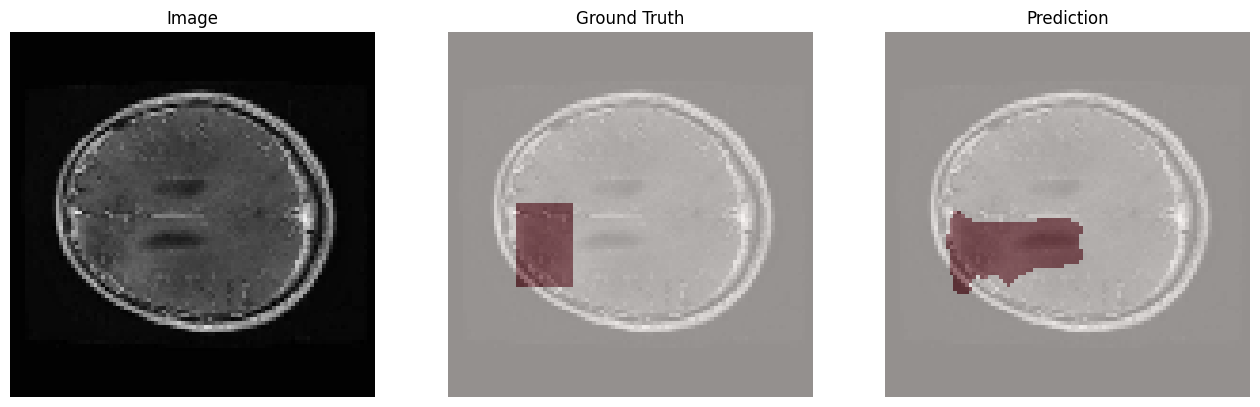


========== EPOCH 23/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.21it/s, loss=0.111] 



Train Loss: 0.1132
Val Loss:   0.3447
Val IoU:    0.6124
Val Acc:    0.9835
No improvement: 4/8

========== EPOCH 24/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.29it/s, loss=0.111] 



Train Loss: 0.0964
Val Loss:   0.3132
Val IoU:    0.6452
Val Acc:    0.9843
🌟 Best IoU improved 0.6444 → 0.6452

📊 Visual Progress Preview:


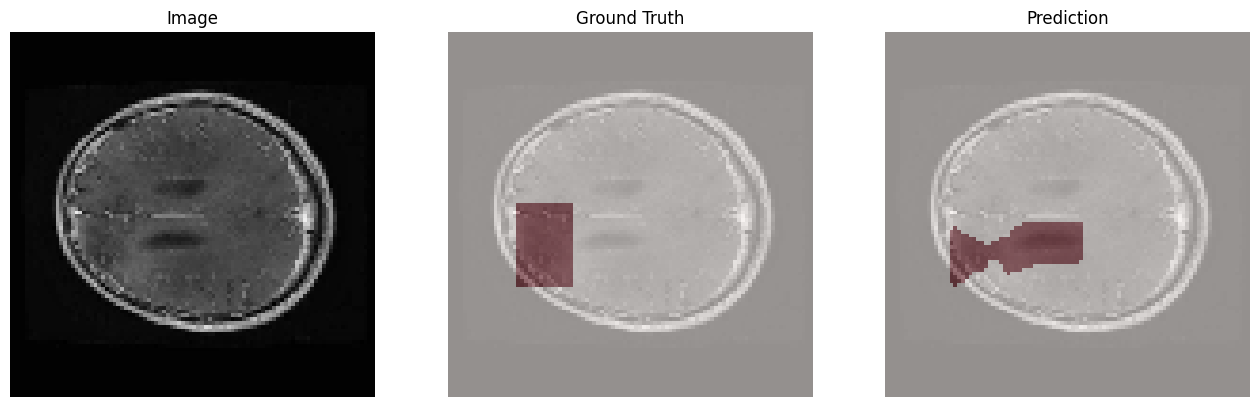


========== EPOCH 25/30 ==========



Training: 100%|██████████| 376/376 [00:34<00:00, 10.82it/s, loss=0.11]  



Train Loss: 0.0851
Val Loss:   0.3265
Val IoU:    0.6334
Val Acc:    0.9838
No improvement: 1/8

========== EPOCH 26/30 ==========



Training: 100%|██████████| 376/376 [00:40<00:00,  9.22it/s, loss=0.0682]



Train Loss: 0.0805
Val Loss:   0.3366
Val IoU:    0.6246
Val Acc:    0.9838
No improvement: 2/8

📊 Visual Progress Preview:


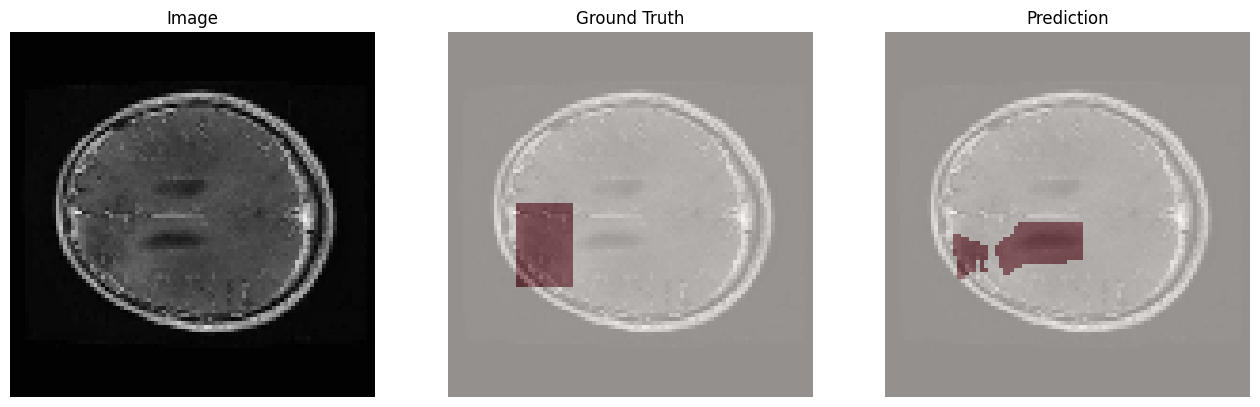


========== EPOCH 27/30 ==========



Training: 100%|██████████| 376/376 [00:36<00:00, 10.20it/s, loss=0.196] 



Train Loss: 0.0744
Val Loss:   0.3325
Val IoU:    0.6307
Val Acc:    0.9841
No improvement: 3/8

========== EPOCH 28/30 ==========



Training: 100%|██████████| 376/376 [00:40<00:00,  9.36it/s, loss=0.096] 



Train Loss: 0.0713
Val Loss:   0.3406
Val IoU:    0.6259
Val Acc:    0.9838
No improvement: 4/8

📊 Visual Progress Preview:


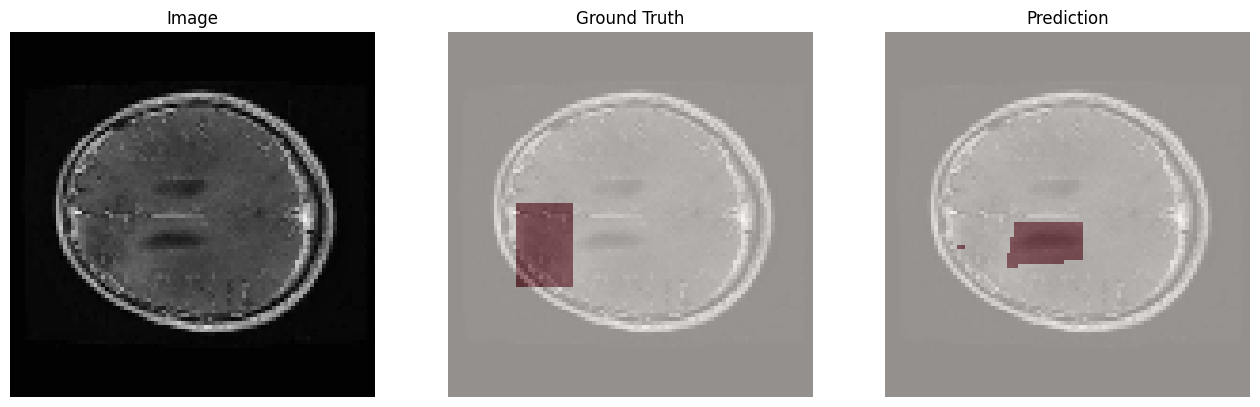


========== EPOCH 29/30 ==========



Training: 100%|██████████| 376/376 [00:33<00:00, 11.12it/s, loss=0.0548]



Train Loss: 0.0621
Val Loss:   0.3273
Val IoU:    0.6386
Val Acc:    0.9842
No improvement: 5/8

========== EPOCH 30/30 ==========



Training: 100%|██████████| 376/376 [00:31<00:00, 11.86it/s, loss=0.105] 



Train Loss: 0.0555
Val Loss:   0.3320
Val IoU:    0.6361
Val Acc:    0.9843
No improvement: 6/8

📊 Visual Progress Preview:


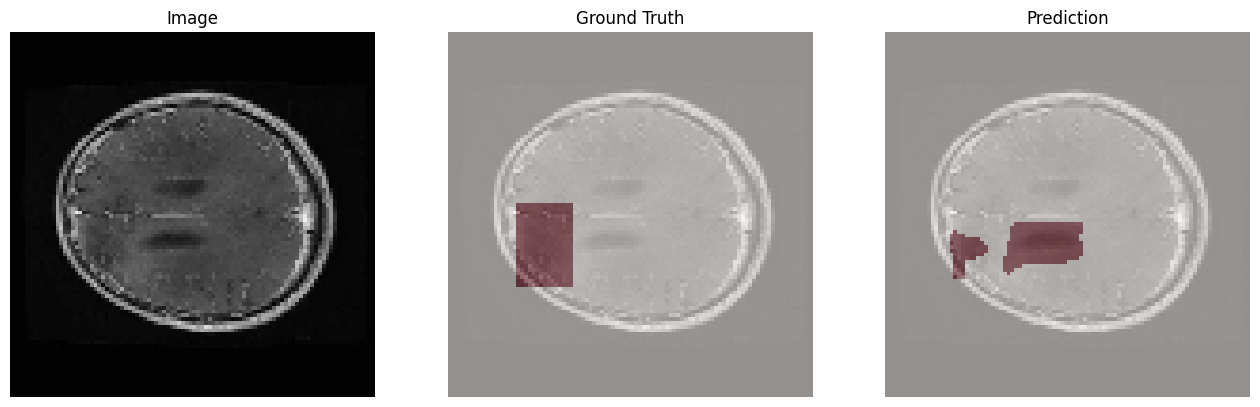


Training finished.
Best IoU achieved: 0.6451587906285894


In [47]:
# ==========================================================
# TRAINING LOOP (MPS SAFE) + PROGRESS BAR + VISUAL PREVIEW
# ==========================================================
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using:", DEVICE)

model = UNetStable128().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=3, factor=0.5, verbose=True
)

best_iou = 0
patience = 8
counter = 0
max_epochs = 30


def show_visual_progress(model, loader):
    """Show overlay of image + ground truth + prediction."""
    model.eval()
    with torch.no_grad():
        img, mask = next(iter(loader))
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        pred = torch.sigmoid(model(img))
        pred_bin = (pred > 0.5).float()

        # Convert to numpy
        img_np = img[0].permute(1,2,0).cpu().numpy()
        img_np = img_np * 0.5 + 0.5  # unnormalize
        mask_np = mask[0,0].cpu().numpy()
        pred_np = pred_bin[0,0].cpu().numpy()

        plt.figure(figsize=(16,5))

        plt.subplot(1,3,1)
        plt.title("Image")
        plt.imshow(img_np)
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Ground Truth")
        plt.imshow(img_np, alpha=0.7)
        plt.imshow(mask_np, cmap="Reds", alpha=0.4)
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Prediction")
        plt.imshow(img_np, alpha=0.7)
        plt.imshow(pred_np, cmap="Reds", alpha=0.4)
        plt.axis("off")

        plt.show()


print("\n🚀 Starting Training...\n")

for epoch in range(1, max_epochs + 1):
    print(f"\n========== EPOCH {epoch}/{max_epochs} ==========\n")

    model.train()
    running_loss = 0

    loop = tqdm(train_loader, desc="Training", leave=True)

    for images, masks in loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)

    # VALIDATION
    val_loss, val_iou, val_acc = validate_one_epoch(model, val_loader, criterion)

    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")

    scheduler.step(val_iou)

    # --- EARLY STOPPING ---
    if val_iou > best_iou:
        print(f"🌟 Best IoU improved {best_iou:.4f} → {val_iou:.4f}")
        best_iou = val_iou
        counter = 0
        torch.save(model.state_dict(), "../experiments/best_model_mps.pth")
    else:
        counter += 1
        print(f"No improvement: {counter}/{patience}")
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

    # --- VISUAL PROGRESS EVERY 2 EPOCHS ---
    if epoch % 2 == 0:
        print("\n📊 Visual Progress Preview:")
        show_visual_progress(model, val_loader)

print("\nTraining finished.")
print("Best IoU achieved:", best_iou)